In [3]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report

In [4]:
file_path = 'dataset_blood_group'

# List all classes in the dataset
name_class = os.listdir(file_path)
print(name_class)

['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


In [5]:
# Get file paths for all images in the dataset
filepaths = list(glob.glob(file_path + '/**/*.*'))

# Example of printing a subset of file paths
print(filepaths[-6:-1])

# Extract labels from file paths
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
print(labels)

['dataset_blood_group\\O-\\cluster_7_964.BMP', 'dataset_blood_group\\O-\\cluster_7_977.BMP', 'dataset_blood_group\\O-\\cluster_7_979.BMP', 'dataset_blood_group\\O-\\cluster_7_985.BMP', 'dataset_blood_group\\O-\\cluster_7_998.BMP']
['A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 

                                     Filepath Label
0  dataset_blood_group\AB-\cluster_5_5519.BMP   AB-
1   dataset_blood_group\B+\cluster_2_2909.BMP    B+
2  dataset_blood_group\AB+\cluster_4_3223.BMP   AB+
3   dataset_blood_group\O+\cluster_6_4469.BMP    O+
4   dataset_blood_group\O-\cluster_7_4239.BMP    O-


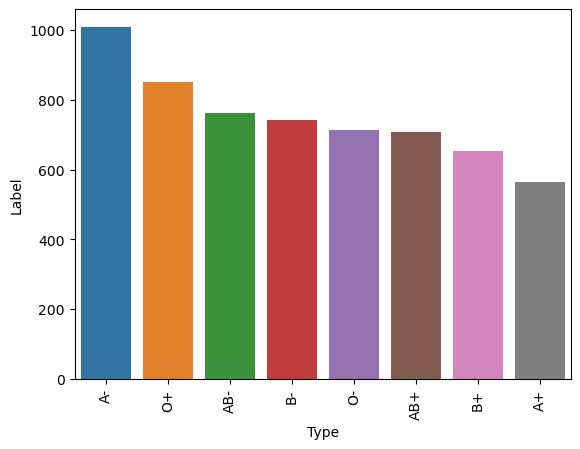

In [6]:
# Create a DataFrame with file paths and labels
filepath = pd.Series(filepaths, name='Filepath').astype(str)
Labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, Labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
print(data.head(5))

# Visualize class distribution
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90)
plt.show()

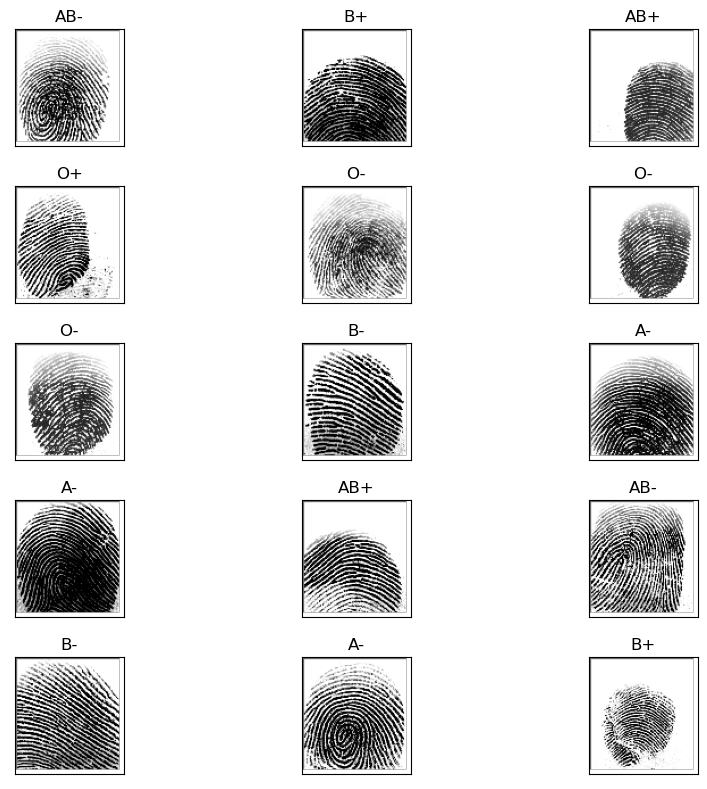

In [7]:
# Split data into training and testing sets
train, test = train_test_split(data, test_size=0.20, random_state=42)

# Visualize some images from the dataset
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [8]:
# Set up ImageDataGenerator for training and validation data
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 4800 validated image filenames belonging to 8 classes.
Found 1200 validated image filenames belonging to 8 classes.


In [9]:
from tensorflow.keras.applications import VGG16

# Define the base pre-trained model
vgg16_base = VGG16(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

vgg16_base.trainable = False

# Add layers for classification on top of VGG16
x = Dense(128, activation="relu")(vgg16_base.output)
x = Dense(128, activation="relu")(x)
outputs = Dense(8, activation='softmax')(x)

vgg16_model = Model(inputs=vgg16_base.input, outputs=outputs)

vgg16_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = vgg16_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
)

58889256/58889256 [==============================] - 23s 0us/step
Epoch 1/20
150/150 [==============================] - 1181s 8s/step - loss: 1.4881 - accuracy: 0.4765 - val_loss: 0.9685 - val_accuracy: 0.6300
Epoch 2/20
150/150 [==============================] - 1082s 7s/step - loss: 0.8375 - accuracy: 0.6798 - val_loss: 0.9460 - val_accuracy: 0.6483
Epoch 3/20
150/150 [==============================] - 1035s 7s/step - loss: 0.6971 - accuracy: 0.7360 - val_loss: 0.9447 - val_accuracy: 0.6392
Epoch 4/20
150/150 [==============================] - 1007s 7s/step - loss: 0.6095 - accuracy: 0.7660 - val_loss: 0.7554 - val_accuracy: 0.7125
Epoch 5/20
150/150 [==============================] - 1036s 7s/step - loss: 0.5160 - accuracy: 0.8050 - val_loss: 0.6732 - val_accuracy: 0.7442
Epoch 6/20
150/150 [==============================] - 1061s 7s/step - loss: 0.4627 - accuracy: 0.8229 - val_loss: 0.8262 - val_accuracy: 0.6950
Epoch 7/20
150/150 [==============================] - 1072s 7s/step - 

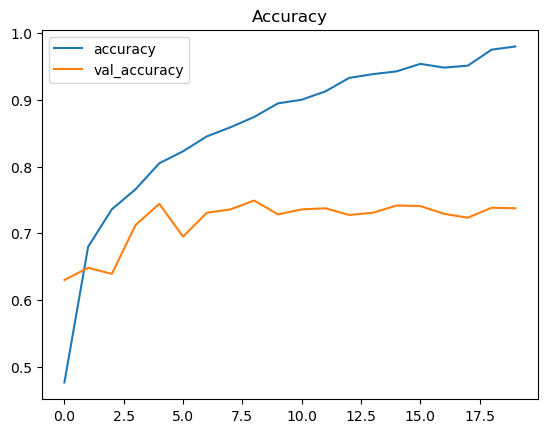

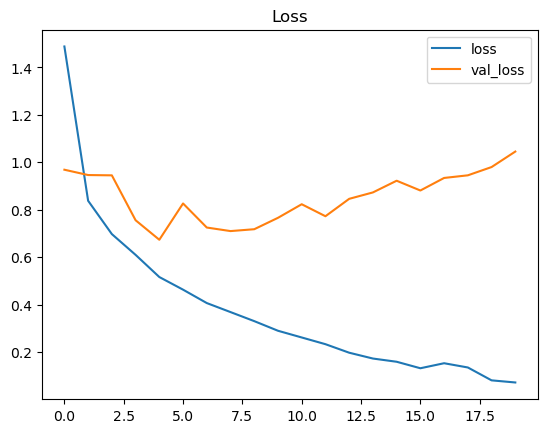

Test Loss: 1.04504
Test Accuracy: 73.75%
38/38 [==============================] - 358s 9s/step
              precision    recall  f1-score   support

          A+       0.88      0.75      0.81       105
          A-       0.71      0.60      0.65       210
         AB+       0.75      0.72      0.73       135
         AB-       0.67      0.78      0.72       134
          B+       0.73      0.65      0.69       141
          B-       0.80      0.89      0.84       155
          O+       0.71      0.78      0.75       183
          O-       0.70      0.77      0.73       137

    accuracy                           0.74      1200
   macro avg       0.75      0.74      0.74      1200
weighted avg       0.74      0.74      0.74      1200



In [11]:
# Plot training history: accuracy
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# Plot training history: loss
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

# Evaluate the model on test data
results = vgg16_model.evaluate(valid_gen, verbose=0)
print(f"Test Loss: {results[0]:.5f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")

# Predict labels for test data
pred = vgg16_model.predict(valid_gen)
pred = np.argmax(pred, axis=1)

# Map predicted labels
labels = train_gen.class_indices
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Compare predicted labels with true labels and print classification report
y_test = list(test.Label)
print(classification_report(y_test, pred))

In [12]:
vgg16_model.save("blood_group_detection.h5")

C:\Users\varun\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


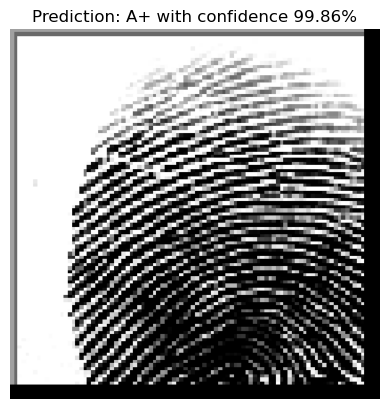

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Load the pre-trained model
model = load_model('model_blood_group_detection_vgg16.h5')

# Define the class labels
labels = {'A+': 0, 'A-': 1, 'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7}
labels = dict((v, k) for k, v in labels.items())

# Example of loading a single image and making a prediction
img_path = 'dataset_blood_group/A+/cluster_0_1001.BMP'

img = image.load_img(img_path, target_size=(256, 256))  # Load the image
x = image.img_to_array(img)  # Convert image to array
x = np.expand_dims(x, axis=0)  # Expand dimensions to match the model input
x = preprocess_input(x)  # Preprocess the image

result = model.predict(x)  # Predict using the model
predicted_class = np.argmax(result)  # Get the predicted class index

# Map the predicted class to the label
predicted_label = labels[predicted_class]
confidence = result[0][predicted_class] * 100  # Confidence level

# Display the image
plt.imshow(image.array_to_img(image.img_to_array(img) / 255.0))
plt.axis('off')  # Hide axes

# Display the prediction and confidence below the image
plt.title(f"Prediction: {predicted_label} with confidence {confidence:.2f}%")
plt.show()
